In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from matplotlib import gridspec

In [21]:
# set inital values
line = 1403.
mass = 28.0*1.66054e-27
kb = 1.3807e-23
c = 300
h = 6.62607e-27
flux=1.0e3 #? why this val?
ll = np.arange(line-10,line+10,0.01)

In [22]:
#tube = readsav('dat/f4.sav',verbose=True,python_dict=True)
tube = readsav('/Users/WilliamHenryAshfieldIV/spring2020/dat/f4.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/spring2020/dat/f4_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/spring2020/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [24]:
# define arrays from tube.tarr
t = tube.tarr.t[time]
n = tube.tarr.n[time]
los_v = tube.tarr.v[time].T[0]
sm_v = -savgol_filter(los_v,3,1)
los_x = tube.tarr.x[time].T[0]
n_e = tube.tarr.epamu[time]*tube.tarr.rho[time]/1.67e-8 # number density
b = tube.tarr.b[time]
dl_e = tube.tarr.dl_e[time]

In [127]:
time= 499 # index = 0.1*time in seconds

In [128]:
# interpolate our GofT data
te = 10**log10T
inter = interp1d(te,log10G,kind='cubic', bounds_error=False, fill_value=-10e6) #fill outide vals with large, small number
temp = 1e6*tube.tarr.t[time]
G = inter(temp)
G[temp<22000] = -10000 # set all log10G with low temp to large, small number (st 10^G~0)

In [129]:
# nei/eqi arrays at time =time
f_nei=frac.fraq.f_nei[0]
f_nei = f_nei[:,time]
f_eqi=frac.fraq.f_eqi[0]
f_eqi = f_eqi[:,time]

In [130]:
i_min,i_max = 285,999

In [131]:
t_s = t[i_min:i_max]
n_s = len(t_s)
los_v_s = los_v[i_min:i_max]
sm_v_s = sm_v[i_min:i_max]
los_x_s = los_x[i_min:i_max]
n_e_s = n_e[i_min:i_max]
b_s = b[i_min:i_max]
dl_e_s = dl_e[i_min:i_max]
G_s = G[i_min:i_max]
f_nei_s = f_nei[i_min:i_max]
f_eqi_s = f_eqi[i_min:i_max]

In [132]:
# interpolate
N=10*n_s
i_s = np.arange(0,n_s)
ii = np.arange(0,10*(n_s-1))*0.1

int_x = interp1d(i_s,los_x_s,kind='linear')#,fill_value="extrapolate")
int_v = interp1d(i_s,sm_v_s,kind='linear')
int_t = interp1d(i_s,t_s,kind='linear')
int_ne = interp1d(i_s,n_e_s,kind='linear')
int_b = interp1d(i_s,b_s,kind='linear')
int_dl_e = interp1d(i_s,dl_e_s,kind='linear')
int_G = interp1d(i_s,G_s,kind='linear')
int_fnei = interp1d(i_s,f_nei_s,kind='linear')
int_feqi = interp1d(i_s,f_eqi_s,kind='linear')

# new, interpolated arrays from tarr/tube
x = int_x(ii)
v = int_v(ii)
T = int_t(ii)
ne = int_ne(ii)
B = int_b(ii)
Dl = int_dl_e(ii)
g = int_G(ii)
nei = int_fnei(ii)
eqi = int_feqi(ii)

# factor to multiply GofT by to get actual emission given NEI
factor = nei/eqi
np.nan_to_num(factor, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [133]:
# process to create volume given per flux (per Maxwell)
rad=np.sqrt(flux/B/np.pi)
b_e=0.5*( np.roll(B, -1) + B )
A1=rad
A2=np.roll(rad,-1)
A2[(len(B))-1]=A2[len(B)-2]
#volume=(1./3.)*Dl*(A1+A2+np.sqrt(A1*A2))*1e24
A = flux/B # replace by area of pixel in Mm (~0.01 Mm^2)
A_pixel = 0.029 # Mm^2 -  pixel area: 0.33 x 0.167 arcsec (as seen on sun..)

volume = Dl*A_pixel*1e24
#calcualte emission measure EM
EM=volume*ne**2

In [134]:
# calculate prefactor to turn intensity into counts
photo_erg = h*c*1e6/line*1e10 #erg/photon
pixel_size = 12.8e-3 # in ˚A [12.8 m˚A (FUV), 25.6 m˚A (NUV)]
#FOV = 0.33*175*2.35e-11 # in sr 0.33 × 175 arcsec^2 SG-slit
dim = 19e-2
A_iris = 2.2e-4 # effective area FUV
au = 1.49e11
atn = A_iris/au**2
exp_time = 4
#photo_fac = pixel_size*atn*exp_time/photo_erg # converts EM*g/sig (erg/s/sr/˚A) -> photon count
photo_fac = pixel_size*atn*exp_time/photo_erg

In [135]:
# determine line broadening given combination of thermal, non-thermal, and instrumental broadenings
freq = c/line*1e3
v_inst = 3.9 # instrumental broadening (km/s)
sig_inst = v_inst/freq
v_nt = 20.0 # non-thermal broadening (km/s) [De Pontieu et al, 2015]
sig_nt = v_nt/freq
sig_th = line*np.sqrt(kb*1e6*T/mass)/(c*1e6) # thermal broadening (in ˚A)
sig = np.sqrt(sig_th**2+sig_nt**2+sig_inst**2) # total broadening

# create emission array(s) for each fluid element
nn=10*(n_s-1)
emissNEI = np.empty([nn,len(ll)])
emiss = emissNEI
for i in range(nn):
    emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
    emiss[i,:] = photo_fac*EM[i]*10**g[i]/np.sqrt(2*np.pi*sig[i])*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))

In [136]:
jjs = np.where(emissNEI>1)
np.unique(jjs[0])

array([  90,   91,   92, ..., 2698, 2699, 2700])

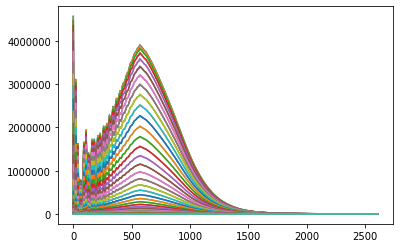

In [138]:
plt.plot(emiss[90:2699]);

(1402, 1405)

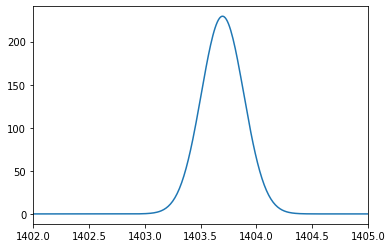

In [50]:
tot_emissNEI = np.sum(emissNEI,axis=0)
plt.plot(ll,tot_emissNEI)
plt.xlim(1402,1405)